#### Trying out XGBoost since our Data is highly Imbalanced

We can either use approaches to oversample the minority class or we can use XGBoost and balance the positive and negative weights by setting scale_pos_weight to sum (negative instances) / sum (positive instances). </br>

All we are doing in the XGBoost is penalizing the model for predicting the majority class to balance the output. We will come to that later on how to do that.

In [1]:
#----main libraries----
import numpy as np
import pandas as pd

#----plotting libraries----
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#----regular expressions----
import re

#----model and support imports----
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler, 
    PolynomialFeatures,
    KBinsDiscretizer
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('Telco-Churn.csv')

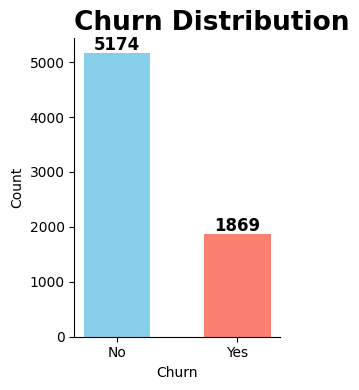

In [3]:
# Get the value counts for 'Churn' column
data_temp = df['Churn'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(3, 4))

# Plotting the bar chart
ax.bar(data_temp.index, data_temp, width=0.55, color=['skyblue', 'salmon'])

# Title and axis labels
ax.set_title('Churn Distribution', loc='left', fontsize=19, fontweight='bold')
ax.set_xlabel('Churn')
ax.set_ylabel('Count')

# Annotate each bar with its count value
for i, count in enumerate(data_temp):
    ax.text(i, count + 50, str(count), ha='center', fontsize=12, fontweight='bold')

# Hide spines on top and right sides
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

In [4]:
#drop customerID
df.drop(columns='customerID', inplace= True)

In [5]:
#Looking for duplicated values
df.duplicated().sum()

22

In [6]:
#drop duplicates rows
df.drop_duplicates(inplace=True)

In [7]:
#Checking missing values
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Data Processing

The above code returns error first and it says it can't convert string object to float. So we need to deal with object values in the Total Charges column

In [8]:
try:
    # Try converting the column to numeric
    pd.to_numeric(df['TotalCharges'])
except ValueError as e:
    # Handle the error (non-numeric values found)
    print(f"Non-integer values found in column '{'TotalCharges'}': {e}")
    # Print or investigate the problematic entries
    problematic_entries = df[~df['TotalCharges'].astype(str).str.isdigit()]
    print("Problematic entries:")

Non-integer values found in column 'TotalCharges': Unable to parse string " " at position 488
Problematic entries:


The above output shows there are empty cells in the 'Total Charges' column (' '). So lets drop them and run the cell which converts type object to integer

In [9]:
TotalCharges = df['TotalCharges'].astype(str).apply(lambda x: x if not re.search('\d+', x)else 'Numeric')
TotalCharges[TotalCharges!='Numeric']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

In [10]:
df.drop(index=TotalCharges[TotalCharges!='Numeric'].index, inplace=True)

In [11]:
columns = df.columns
print("----------- Numeric field ----------\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes!=object:
        print("unique number of {} ---> {}".format(columns[i], len(df[columns[i]].unique())))
        
print("\n---------- Categorical field ----------\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes==object:
        print("unique number of {} ---> {}".format(columns[i], len(df[columns[i]].unique())))

----------- Numeric field ----------

unique number of SeniorCitizen ---> 2
unique number of tenure ---> 72
unique number of MonthlyCharges ---> 1584

---------- Categorical field ----------

unique number of gender ---> 2
unique number of Partner ---> 2
unique number of Dependents ---> 2
unique number of PhoneService ---> 2
unique number of MultipleLines ---> 3
unique number of InternetService ---> 3
unique number of OnlineSecurity ---> 3
unique number of OnlineBackup ---> 3
unique number of DeviceProtection ---> 3
unique number of TechSupport ---> 3
unique number of StreamingTV ---> 3
unique number of StreamingMovies ---> 3
unique number of Contract ---> 3
unique number of PaperlessBilling ---> 2
unique number of PaymentMethod ---> 4
unique number of TotalCharges ---> 6530
unique number of Churn ---> 2


In [12]:
#since the column TotalCharges is a type of numeric let's convert it to from object to numeric

df['TotalCharges']= df['TotalCharges'].astype(float)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7010 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   object 
 1   SeniorCitizen     7010 non-null   int64  
 2   Partner           7010 non-null   object 
 3   Dependents        7010 non-null   object 
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   object 
 6   MultipleLines     7010 non-null   object 
 7   InternetService   7010 non-null   object 
 8   OnlineSecurity    7010 non-null   object 
 9   OnlineBackup      7010 non-null   object 
 10  DeviceProtection  7010 non-null   object 
 11  TechSupport       7010 non-null   object 
 12  StreamingTV       7010 non-null   object 
 13  StreamingMovies   7010 non-null   object 
 14  Contract          7010 non-null   object 
 15  PaperlessBilling  7010 non-null   object 
 16  PaymentMethod     7010 non-null   object 
 17  

In [14]:
spw = -(-df[df.Churn == "No"].shape[0]// df[df.Churn == "Yes"].shape[0])

print("XGBoost weight balancing ---> neg: {}, pos: {}, scale_pos_weight: {}".format(df[df.Churn == "No"].shape[0], df[df.Churn == "Yes"].shape[0], spw))

XGBoost weight balancing ---> neg: 5153, pos: 1857, scale_pos_weight: 3


#### Model configuration

We will use XGBoost and then use TensorFlow to see if we get better performance using a Neural Network. <br>
We will use SMOTE (synthetic minority oversampling technique) to correct for imbalance while using TensorFlow.

The mathematical goal of a machine learning algorithm is to find the optimal model parameters that minimize the cost function, also known as the loss function, over the training data. This is typically done through an optimization algorithm such as gradient descent, which iteratively updates the model parameters to minimize the cost function.

Let us first encode our dependent variable (i.e., convert it to 1 and 0):

In [15]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

We will now convert our categorical dependent variables into dummy variables (i.e., generate a separate column for each value and changing the values into 1 and 0):

In [16]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,0,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,False,True,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,0,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


Let us now check correlation between the various variables:

<Axes: >

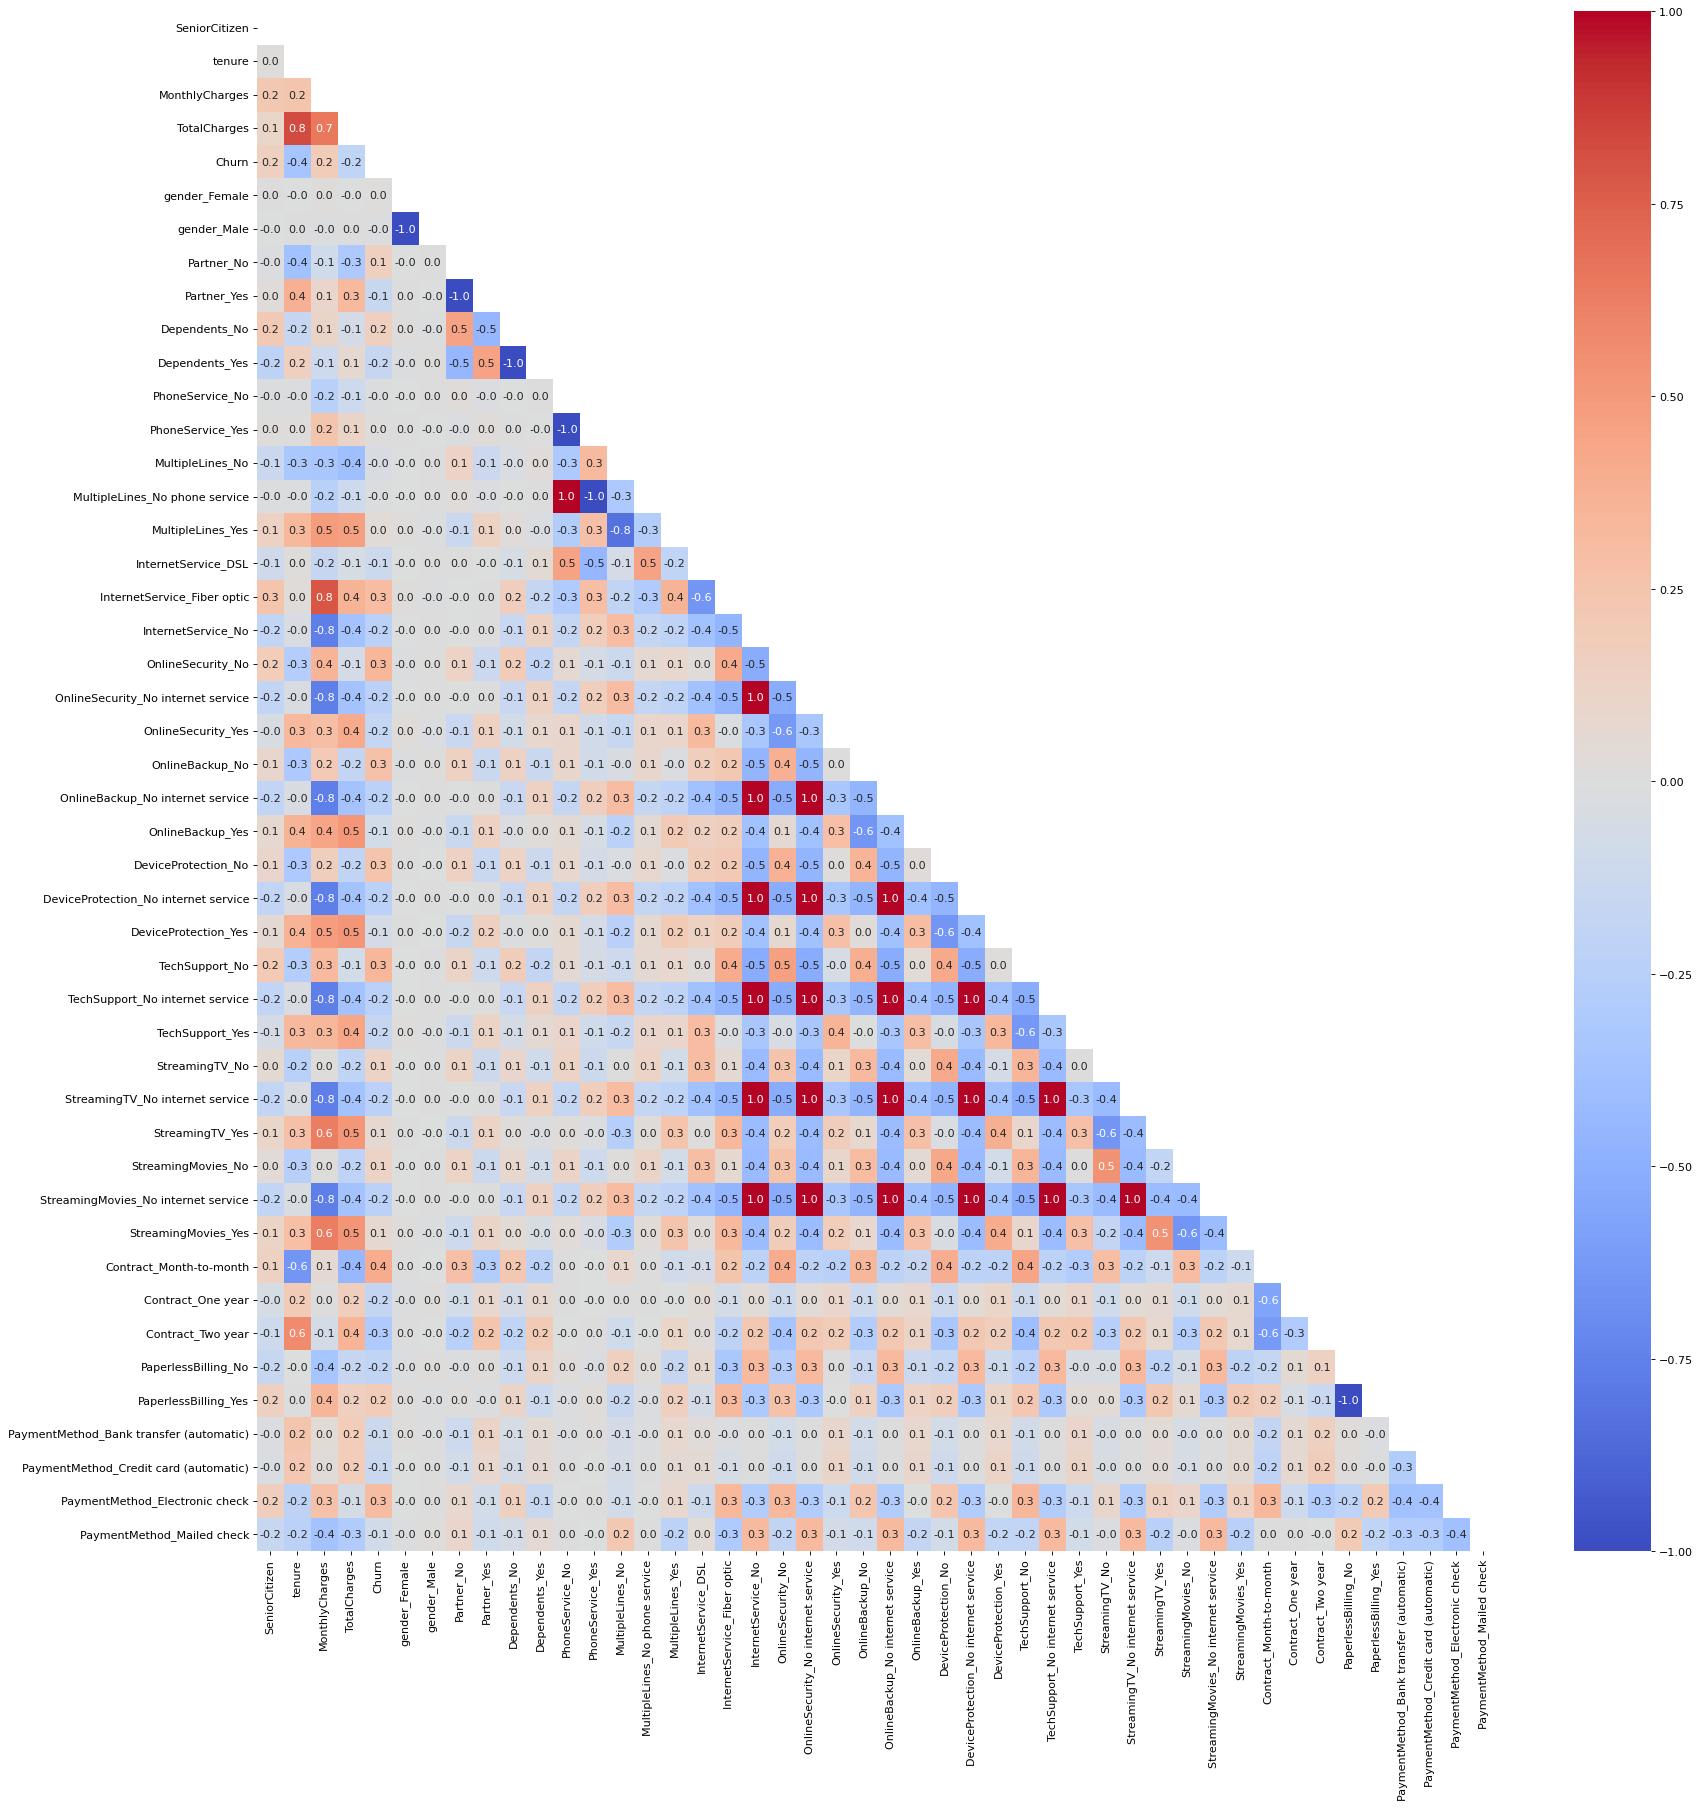

In [17]:
matrix = np.triu(np.ones_like(df_dummy.corr()))
fig, ax = plt.subplots(figsize=(25,25),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df_dummy.corr(), mask= matrix, cmap="coolwarm", annot = True, fmt = '.1f', center = 0,annot_kws={"fontsize":10})

Finding redundant features

In [18]:
from scipy.stats import pearsonr

# Define the correlation threshold
correlation_threshold = 0.8

# Create an empty list to store correlated pairs of features
correlated_pairs = []

# Calculate the correlation matrix
corr_matrix = df_dummy.corr().abs()

# Loop through the upper triangle of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # If the correlation exceeds the threshold
        if corr_matrix.iloc[i, j] > correlation_threshold:
            # Append the pair of features to the list
            correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# Print the correlated pairs of features
print(correlated_pairs)

[('TotalCharges', 'tenure'), ('gender_Male', 'gender_Female'), ('Partner_Yes', 'Partner_No'), ('Dependents_Yes', 'Dependents_No'), ('PhoneService_Yes', 'PhoneService_No'), ('MultipleLines_No phone service', 'PhoneService_No'), ('MultipleLines_No phone service', 'PhoneService_Yes'), ('MultipleLines_Yes', 'MultipleLines_No'), ('OnlineSecurity_No internet service', 'InternetService_No'), ('OnlineBackup_No internet service', 'InternetService_No'), ('OnlineBackup_No internet service', 'OnlineSecurity_No internet service'), ('DeviceProtection_No internet service', 'InternetService_No'), ('DeviceProtection_No internet service', 'OnlineSecurity_No internet service'), ('DeviceProtection_No internet service', 'OnlineBackup_No internet service'), ('TechSupport_No internet service', 'InternetService_No'), ('TechSupport_No internet service', 'OnlineSecurity_No internet service'), ('TechSupport_No internet service', 'OnlineBackup_No internet service'), ('TechSupport_No internet service', 'DeviceProt

In [19]:
# Identify and remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1) == 1)
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df = df.drop(columns=to_drop)
    return df

# Remove highly correlated features from your dataframe
df_cleaned = remove_highly_correlated_features(df_dummy, correlation_threshold)

# Print the cleaned dataframe
print(df_cleaned)

      SeniorCitizen  tenure  MonthlyCharges  Churn  gender_Female  Partner_No   
0                 0       1           29.85      0           True       False  \
1                 0      34           56.95      0          False        True   
2                 0       2           53.85      1          False        True   
3                 0      45           42.30      0          False        True   
4                 0       2           70.70      1           True        True   
...             ...     ...             ...    ...            ...         ...   
7038              0      24           84.80      0          False       False   
7039              0      72          103.20      0           True       False   
7040              0      11           29.60      0           True       False   
7041              1       4           74.40      1          False       False   
7042              0      66          105.65      0          False        True   

      Dependents_No  PhoneS

In [20]:
#Since Churn is our targeted column
X = df_cleaned.drop('Churn', axis=1)  # Use cleaned dataset
y = df_cleaned['Churn']

# Step 1: Data Splitting
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100, test_size = 0.3)
print(y_train.value_counts())

# Step 2: Feature Scaling (if needed)
# Min-Max Scaling (Normalization)
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

# Standardization
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

# Step 3: Model Selection (XGBoost)
xgb_model = XGBClassifier(random_state=42)

# Step 4: Model Training
xgb_model.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred = xgb_model.predict(X_test)
print('Test-------------------')
print(classification_report(y_test, y_pred))
print('Accuracy score:', accuracy_score(y_test, y_pred))

Churn
0    3634
1    1273
Name: count, dtype: int64
Test-------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1519
           1       0.65      0.52      0.57       584

    accuracy                           0.79      2103
   macro avg       0.74      0.70      0.72      2103
weighted avg       0.78      0.79      0.78      2103

Accuracy score: 0.7869709938183548


In [21]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'scale_pos_weight': [1, 2, 3, 4, 5]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,  # Adjust the number of iterations as needed
    scoring='accuracy',  # Use the appropriate metric for your problem
    cv=5,  # Adjust the number of folds in cross-validation as needed
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_standard, y_train)

# Display the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Use the best model for predictions
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_standard)

# Evaluate the tuned model
print('Test-------------------')
print(classification_report(y_test, y_pred_tuned))
print('Accuracy score:', accuracy_score(y_test, y_pred_tuned))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.7}
Test-------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1519
           1       0.63      0.52      0.57       584

    accuracy                           0.78      2103
   macro avg       0.73      0.70      0.71      2103
weighted avg       0.77      0.78      0.77      2103

Accuracy score: 0.7812648597242036


In [22]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1354  165]
 [ 283  301]]


True Positives (TP): 301 </br>
True Negatives (TN): 1354 </br>
False Positives (FP): 165 </br>
False Negatives (FN): 283 </br>

##### Now lets unerstand the Matrix here:</br>

Precision:
Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of the accuracy of the positive predictions.

Precision for class 0 (Churn = 0): 1354 / (1354 + 165) ≈ 0.891
Precision for class 1 (Churn = 1): 301 / (301 + 283) ≈ 0.515
Recall (Sensitivity or True Positive Rate):
Recall is the ratio of correctly predicted positive observations to all observations in the actual class. It measures the ability of the model to capture all the relevant cases.

Recall for class 0: 1354 / (1354 + 283) ≈ 0.827
Recall for class 1: 301 / (301 + 165) ≈ 0.646
F1-Score:
The F1-Score is the weighted average of precision and recall. It provides a balance between precision and recall.

F1-Score for class 0: ≈ 0.858
F1-Score for class 1: ≈ 0.573
Accuracy:
Overall accuracy of the model on the test set.

Accuracy: 0.774 (77.4%)
These values are derived from the confusion matrix and classification report you provided earlier. If you have any further questions or if there's anything else you'd like to explore, feel free to let me know! </br>

##### Interpretation: </br>

Accuracy (overall correct predictions): 78.13%</br>

The model correctly predicts the class for approximately 78% of the instances.</br>
Precision (accuracy of positive predictions):</br>

Precision for class 0 (No Churn): 0.83</br>
Precision for class 1 (Churn): 0.63</br>
This indicates the percentage of correctly predicted instances among the predicted instances for each class.</br>
Recall (true positive rate or sensitivity):</br>

Recall for class 0 (No Churn): 0.88</br>
Recall for class 1 (Churn): 0.52</br>
This shows the percentage of correctly predicted instances among the actual instances for each class.</br>
F1-Score (harmonic mean of precision and recall):</br>

F1-score for class 0 (No Churn): 0.85</br>
F1-score for class 1 (Churn): 0.57</br>
It provides a balance between precision and recall.</br>

In [23]:
import joblib

# Assuming 'model' is your trained XGBoost model
joblib.dump(xgb_model, 'xgboost_model.joblib')


['xgboost_model.joblib']